1. Euclidian distance function [4 points]
============
The squared Euclidean distance between two D-dimensional vectors x and z is given by
$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$

$\norm{\mathbf{x} - \mathbf{z}}_{2}^{2} = (\mathbf{x} - \mathbf{z})^\top(\mathbf{x} - \mathbf{z}) = \sigma_{d=1}^{D}(X_d - Z_d)^2$

In [95]:
import tensorflow as tf;
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

ImportError: No module named 'PIL'

In [2]:
def euclidianDist(a, b):
    x_z = (tf.expand_dims(a,0) - tf.expand_dims(b,1))
    return tf.transpose(tf.reduce_sum(tf.multiply(x_z, x_z), 2))

# Alternative Solution
# def distanceFunc(X, Z):
#    return tf.reduce_sum((tf.expand_dims(X, 2) - tf.expand_dims(tf.transpose(Z), 0))**2, 1)

a = np.array([[0,0],[0,1],[0,2]])
b = np.array([[1,0],[1,1],[1,2],[1,3],[1,4]])

print('a = ')
print(a)
print('b = ')
print(b)
print('Distance Matrix = ')
print(sess.run(euclidianDist(a,b)))

a = 
[[0 0]
 [0 1]
 [0 2]]
b = 
[[1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]]
Distance Matrix = 
[[ 1  2  5 10 17]
 [ 2  1  2  5 10]
 [ 5  2  1  2  5]]


2. Making Predictions for Regression [6 points]
============
### Data Setup

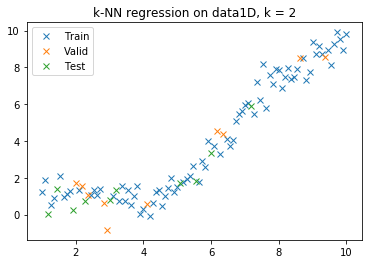

In [3]:
# Generating Data
k = 2

np.random.seed(521)
Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
         + 0.5 * np.random.randn(100 , 1)
randIdx = np.arange(100)
np.random.shuffle(randIdx)
trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

# Draw the plot
line = plt.figure()
plt.title('k-NN regression on data1D, k = ' + str(k))
plt.plot(trainData, trainTarget, "x")
plt.plot(validData, validTarget, "x")
plt.plot(testData, testTarget, "x")
plt.legend(['Train', 'Valid', 'Test'])
plt.show()

### 2.1 Choosing the nearest neighbours [2 points]

In [79]:
# def pickKNearest(Distance, K=50):
#      numTrainData = tf.shape(Distance)[1]
#      dist_k, ind_k = tf.nn.top_k(-Distance, k = K)
#      R = tf.reduce_sum(tf.to_float(tf.equal(tf.expand_dims(ind_k,2),
#                               tf.reshape(tf.range(numTrainData), [1,1,-1]))),1)
#      return R/tf.to_float(K)

def pickKNearestNeighboursUnscaled(DistMatrix, k):
    length = tf.shape(DistMatrix)[1]
    
    values, indices = tf.nn.top_k(-DistMatrix, k)
    range = tf.range(length)
    
    rangeblock = tf.expand_dims(tf.expand_dims(range, 0),0)
    indexblock = tf.expand_dims(indices, 2)
    
    truth_matrix = tf.reduce_sum(tf.to_float(tf.equal(rangeblock, indexblock)),1)

    return truth_matrix

def pickKNearestNeighbours(DistMatrix, k):
    length = tf.shape(DistMatrix)[1]
    
    values, indices = tf.nn.top_k(-DistMatrix, k)
    range = tf.range(length)
    
    rangeblock = tf.expand_dims(tf.expand_dims(range, 0),0)
    indexblock = tf.expand_dims(indices, 2)
    
    truth_matrix = tf.reduce_sum(tf.to_float(tf.equal(rangeblock, indexblock)),1)

    return truth_matrix / tf.to_float(k)

print(sess.run(pickKNearestNeighbours(euclidianDist(a,b),3)))


[[0.33333334 0.33333334 0.33333334 0.         0.        ]
 [0.33333334 0.33333334 0.33333334 0.         0.        ]
 [0.         0.33333334 0.33333334 0.33333334 0.        ]]


### 2.2 Prediction [4 points]

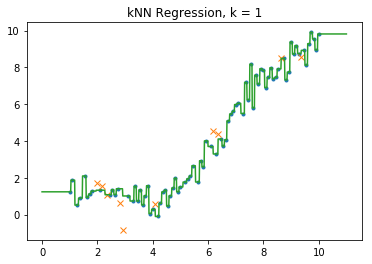

(K = 1)	MSE values: Valid = 0.5430993, Test = 0.622008, Train = 0.0


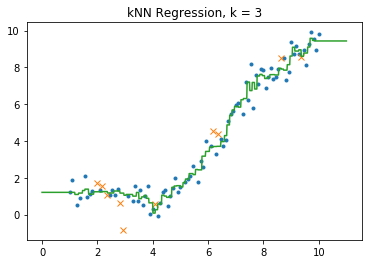

(K = 3)	MSE values: Valid = 0.6525566, Test = 0.29018393, Train = 0.21048422


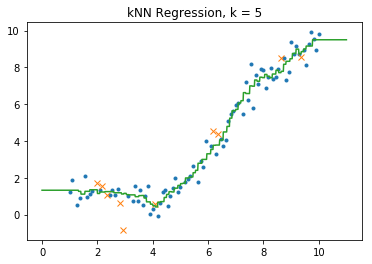

(K = 5)	MSE values: Valid = 0.6208772, Test = 0.35665315, Train = 0.23708253


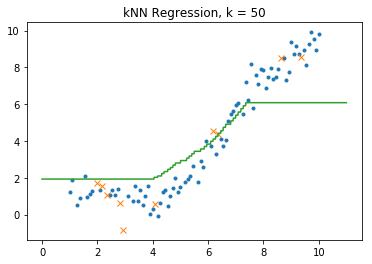

(K = 50)	MSE values: Valid = 2.4574032, Test = 1.4138691, Train = 2.4960175
Value of K for lowest MSE in valid data set is 1


In [5]:

def predictFinalValue(inputX, trainX, trainY, K):
    Knearest = pickKNearestNeighbours(euclidianDist(inputX, trainX), K)
    return tf.matmul(Knearest, trainY)

# The number of nearest neighbours
K = tf.placeholder(tf.int32, name='K')

# The X and Y of the input that the data recieves
trainX = tf.placeholder(tf.float32, [None, 1])
trainY = tf.placeholder(tf.float32, [None, 1])

# K nearest takes the new test input X. Finds the K nearest matrix and multiplies with the training Y output
inputX = tf.placeholder(tf.float32, [None, 1]) # The X that we want to find a predicted Y
inputY = tf.placeholder(tf.float32, [None, 1]) # The actual correct value for Y

predictedY = predictFinalValue(inputX, trainX, trainY, K)

# Mean Squared Error Loss
MSE = tf.reduce_mean(tf.reduce_sum((predictedY - inputY) ** 2, 1))


## Training Tests
k_list = [1,3,5,50]
MSEValid_list = []
MSETest_list = []

PreciseX = np.linspace(0.0, 11.0, num = 1000)[:, np.newaxis]

for k in k_list:
    # Valid
    PredYvalid, MSEvalid = sess.run([predictedY, MSE], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:validData,
        inputY:validTarget,
        K:k})
    MSEValid_list.append(MSEvalid)
    
    # Test
    PredYtest, MSEtest = sess.run([predictedY, MSE], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:testData,
        inputY:testTarget,
        K:k})
    MSETest_list.append(MSEtest)
    
    # Train
    PredYtrain, MSEtrain = sess.run([predictedY, MSE], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:trainData,
        inputY:trainTarget,
        K:k})
    
    # All
    PredYall, MSEall = sess.run([predictedY, MSE], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:Data,
        inputY:Target,
        K:k})
    
    # X input
    PredYprecise = sess.run(predictedY, feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:PreciseX,
        K:k})
    
    # Draw the Plot
    plt.figure(k)
    plt.plot(trainData,trainTarget,".")
    plt.plot(validData,validTarget,"x")
    plt.plot(PreciseX,PredYprecise,"-")
    plt.title("kNN Regression, k = %d"%k)
    plt.show()
    
    # MSE Information
    print('(K = ' + str(k) + ')\tMSE values: Valid = ' + str(MSEvalid) + ', Test = ' + str(MSEtest) + ', Train = ' + str(MSEtrain))

MSEvalidbestindex = np.argmin(MSEValid_list)
Kbest = k_list[MSEvalidbestindex]
print("Value of K for lowest MSE in valid data set is " + str(Kbest))

3. Making Predictions for Classification [10 points]
============
### Data Setup

In [64]:
def data_segmentation(data_path, target_path, task):
    # task = 0 >> select the name ID targets for face recognition task
    # task = 1 >> select the gender ID targets for gender recognition task data = np.load(data_path)/255
    data = np.load(data_path)/255
    data = np.reshape(data, [-1, 32*32])
    
    target = np.load(target_path)
    np.random.seed(45689)
    rnd_idx = np.arange(np.shape(data)[0])
    np.random.shuffle(rnd_idx)
    trBatch = int(0.8*len(rnd_idx))
    validBatch = int(0.1*len(rnd_idx))
    trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
                                   data[rnd_idx[trBatch+1:trBatch + validBatch],:],\
                                   data[rnd_idx[trBatch + validBatch+1:-1],:]
    trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
                              target[rnd_idx[trBatch+1:trBatch + validBatch], task],\
                              target[rnd_idx[trBatch + validBatch + 1:-1], task]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation('data.npy', 'target.npy', 0)
runCount = validData.shape[0]

### Predicting Class Label [4 pts]

In [92]:
def predictFinalValue(inputX, trainX, trainY, K):
    Knearest = pickKNearestNeighboursUnscaled(euclidianDist(inputX, trainX), K)
    predictionMatrix = tf.multiply(Knearest, trainY + 1)

    outputY = tf.zeros(0)    
    for i in range(0, runCount):
        y, idx, count = tf.unique_with_counts(predictionMatrix[i])
        count2 = tf.slice(count, [1], tf.shape(count)-1)
        item_class = tf.expand_dims(y[tf.argmax(count2)+1],0)
        outputY = tf.concat([outputY, item_class],0)
    
    outputY = outputY - 1
    return tf.to_int32(outputY)

# Tensorflow inputs
inputX = tf.placeholder(tf.float32, [None, 32*32])
inputY = tf.placeholder(tf.float32, [None])
trainX = tf.placeholder(tf.float32, [None, 32*32])
trainY = tf.placeholder(tf.float32, [None])
K = tf.placeholder(tf.int32, name='K')

predictY = predictFinalValue(inputX, trainX, trainY, K)
accuracy = tf.reduce_sum(tf.to_int32(tf.equal(predictY, tf.to_int32(inputY))))

### Face Recognition using k-NN [4 pts]

[3 1 2 1 5 0 1 2 4 0 3 2 2 2 4 3 1 1 4 0 4 5 2 3 3 5 5 4 0 4 5 1 0 2 2 1 0
 0 5 3 1 1 2 2 1 5 1 5 3 1 5 0 1 4 1 5 4 1 0 5 0 1 2 5 2 5 0 2 3 2 0 0 2 3
 3 4 2 5 0 1 3 2 2 5 1 5 5 0 0 4 5 1]
Correctly Classified: 61/92


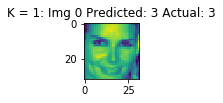

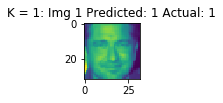

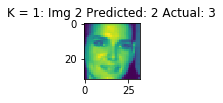

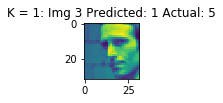

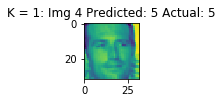

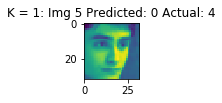

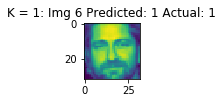

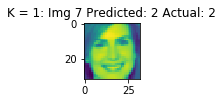

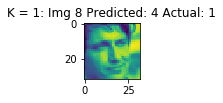

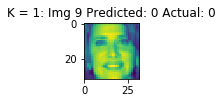

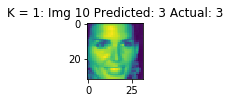

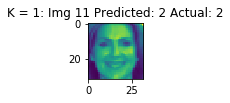

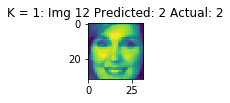

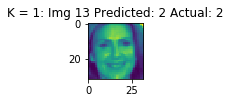

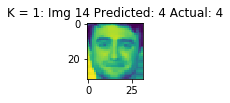

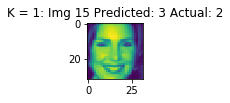

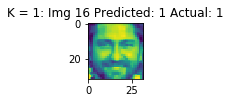

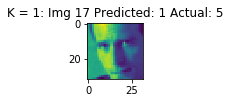

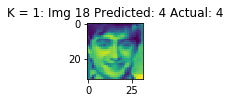

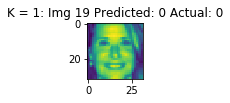

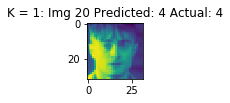

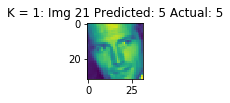

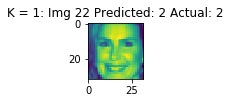

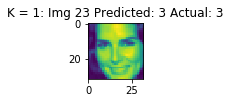

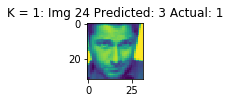

In [ ]:
k_list = [1, 5, 10, 25, 50, 100, 200]

for k in k_list:
    runCount = validData.shape[0]
    prediction, error = sess.run([predictY, accuracy], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:validData,
        inputY:validTarget,
        K:k
        })
    print(prediction)
    print("Correctly Classified: " + str(error) + "/" + str(runCount))
    
    j = 0;
    for i in range(0, runCount):
        plt.figure(figsize = (1,2))
        img = np.reshape(validData[i], (32, 32))
        plt.imshow(img, interpolation='nearest')
        plt.title("K = " + str(k) + ": Img " + str(i) + " Predicted: " + str(prediction[i]) + " Actual: " + str(validTarget[i]))
        plt.show()



### Gender Recognition using k-NN [2 pts]